<a href="https://colab.research.google.com/github/Gooogr/Book_Ian_Pointer_PyTorch_for_DL/blob/master/Chapter%202.%20Perceptron%20image%20classificator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms

from PIL import Image

import numpy as np
import cv2
import urllib.request

from google.colab.patches import cv2_imshow

In [2]:
! nvidia-smi

Tue Sep  1 16:59:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
BATCH_SIZE = 32
INPUT_SIZE = 64

**Prepare dataset**

In [4]:
! mkdir ch2
% cd ch2
! wget --quiet https://raw.githubusercontent.com/falloutdurham/beginners-pytorch-deep-learning/master/chapter2/download.py
! wget --quiet https://raw.githubusercontent.com/falloutdurham/beginners-pytorch-deep-learning/master/chapter2/images.csv

/content/ch2


In [5]:
%%capture
!python download.py
% cd ../

# Takes ~ 20 min in google collab

Remove 0 bytes images

In [6]:
files = [os.path.join(r,file) for r,d,f in os.walk("./ch2") for file in f]
files[:5]

['./ch2/download.py',
 './ch2/images.csv',
 './ch2/val/fish/DanCarleCoho.thumb.jpg',
 './ch2/val/fish/jimmy.jpg',
 './ch2/val/fish/AhappygroupwithsomeniceCohoSalmonsm.jpg']

In [7]:
for file in files:
    if os.path.getsize(file) == 0:
        os.remove(file)

Setting up directories pathes

In [8]:
train_path = './ch2/train/'
val_path = './ch2/val/'
test_path = './ch2/test/'

Create datasets with ImageFolder

In [9]:
img_transforms = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], #pre-compute constants
                         std=[0.229, 0.224, 0.225])
])

In [10]:
def check_image(path):
    '''
    Function will do a sanity check to make sure PIL can actually open the file.
    Passed to the is_valid_file parameter in the ImageFolder.
    '''
    try:
        im = Image.open(path)
        return True
    except:
        return False

In [11]:
train_data = torchvision.datasets.ImageFolder(root=train_path, transform=img_transforms, is_valid_file=check_image)
val_data = torchvision.datasets.ImageFolder(root=val_path, transform=img_transforms, is_valid_file=check_image)
test_data = torchvision.datasets.ImageFolder(root=test_path, transform=img_transforms, is_valid_file=check_image)

Create data loaders

In [12]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

**Create model**

In [13]:
class SimpleNet(nn.Module):
    
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(INPUT_SIZE * INPUT_SIZE * 3, 84)
        self.fc2 = nn.Linear(84, 50)
        self.fc3 = nn.Linear(50, 2)
        
    def forward(self, x):
        x = x.view(-1 , INPUT_SIZE * INPUT_SIZE * 3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) #Final Softmax will be in the loss function - categorical crossentropy
        return x

In [14]:
simplenet = SimpleNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(simplenet.parameters(), lr=0.001)

**Send model to GPU**

In [16]:
print('Is cuda available? - ', torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
simplenet.to(device)

Is cuda available? -  True


SimpleNet(
  (fc1): Linear(in_features=12288, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

In [17]:
device

device(type='cuda')

**Training**

In [24]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=None, device='cuda'):
    '''
    device option copy on cpu/gpu only batch, not model. Model was sent to cpu/gpu in the cell below!
    '''
    for epoch in range(epochs):
        training_loss = 0
        val_loss = 0
        
        model.train() #set model to the train mode
        for batch in train_loader:
            optimizer.zero_grad() #set gradients to zero for every new bath
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward() # backward propagation
            optimizer.step() # update weights
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
            
        model.eval()
        num_correct = 0
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            val_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        val_loss /= len(val_loader.dataset)
        
        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.\
              format(epoch, training_loss, val_loss, num_correct / num_examples))

          
    

In [25]:
train(simplenet, optimizer, nn.CrossEntropyLoss(), train_loader,val_loader, epochs=5, device=device)

Epoch: 0, Training Loss: 1.96, Validation Loss: 1.34, accuracy = 0.50
Epoch: 1, Training Loss: 0.96, Validation Loss: 0.83, accuracy = 0.66
Epoch: 2, Training Loss: 0.57, Validation Loss: 0.64, accuracy = 0.68
Epoch: 3, Training Loss: 0.41, Validation Loss: 0.66, accuracy = 0.70
Epoch: 4, Training Loss: 0.35, Validation Loss: 0.66, accuracy = 0.72


**Making predictions**

In [26]:
def url_to_image(url, save_path=None):
    '''
    Download the image by url-link, convert it to a NumPy array. Encode it into OpenCV format.
    input:
        url - direct url link to image 
    output:
        OpenCV image.
    '''
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")

    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    if save_path is not None:
        cv2.imwrite(save_path, image)
    else:
        return image

In [40]:
img_url = 'https://images.unsplash.com/photo-1524704654690-b56c05c78a00?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&w=1000&q=80'
url_to_image(img_url, 'sample_img.jpg')

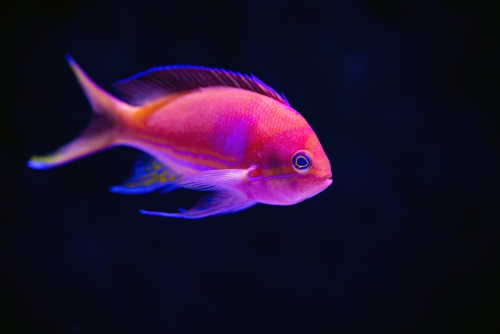

In [42]:
img = cv2.imread('sample_img.jpg')
cv2_imshow(cv2.resize(img, (0, 0), fx=0.5, fy=0.5))

In [57]:
labels = ['cat', 'fish']
img = Image.open('sample_img.jpg')
img = img_transforms(img).to(device)

preds = F.softmax(simplenet(img), dim=1)
print(labels[preds.argmax().item()])


fish


**Saving models**

In [58]:
# Entire model
torch.save(simplenet, "simplenet") 
simplenet = torch.load("simplenet")

In [59]:
# Weights only
torch.save(simplenet.state_dict(), "simplenet")    
simplenet = SimpleNet()
simplenet_state_dict = torch.load("simplenet")
simplenet.load_state_dict(simplenet_state_dict)

<All keys matched successfully>